# IEEE-CIS Fraud Detection

**<div style="text-align: right"> 작성자 : 정호영, 편집자 : 임경태</div>**

- Ref : https://www.kaggle.com/c/ieee-fraud-detection/overview
- Data Description : https://www.kaggle.com/c/ieee-fraud-detection/data
- 문제 제공자 : IEEE Computational Intelligence Society  
- 문제 개요 : 카드 기록을 활용한 사기 거래 탐지  

- 참고  
    - 상당히 주관이 많이 들어가있고, 왜 그렇게 생각했는지 항상 고민해보기  
    - 데이터 컬럼이 비식별화되어 있어, 이전 문제와 다르게 **데이터 탐색을 통한 데이터에 대한 이해**가 매우 중요함
    - 실제 competition 데이터보다 훨씬 경량화가 되어있습니다. 참고하시길 바랍니다. 

## 1. 데이터 불러오기 및 기본 설정

In [24]:
import os
import pandas as pd
import numpy as np
os.chdir('/Users/gangtaro/data_science_repository/Kaggle competition/IEEE-CIS Fraud Detection/')

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'AppleGothic'
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (20, 5)

import warnings
warnings.filterwarnings("ignore")

#### 1.1 데이터 불러오기 및 불필요한 변수 삭제 

In [4]:
df = pd.read_csv("./data/sampled_train_transaction.csv")
print(df.shape)

(100000, 36)


- 비식별화된 Feature가 매우 많음
- 다수 결측이 포함되어있는 Feature가 있음
- Imbalance data
  
  
- TransactionID :  거래 ID (비식별화)
- TranscationDT :  거래 시각 (비식별화)
- TransactionAmt :  거래 금액 (USD)
- ProductCD :  상품 코드
- card1 - card6 :  카드 관련 정보 (비식별화)
- P_emaildomain, R_emaildomain :  이메일 정보
- M1 - M9 :  기존 거래와의 매칭 정보
- isFraud :  사기 거래 여부

원 데이터 설명
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)  
    시간, 비식별화된 데이터 
- TransactionAMT: transaction payment amount in USD  
    거래 금액, 달러 단위
- ProductCD: product code, the product for each transaction  
    무엇을 샀는지에 대한 변수. 
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.  
    카드 유형에 대한 변수들
- addr: address  
    주소. 
- dist: distance  
    거리
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.  
    
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.  

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

In [5]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,1.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,1.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,1.0,T,T,T,M0,F,F,F,F,F
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,1.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
 # 도메인 지식하에, 불필요한 변수라 판단하여 삭제
df.drop(['TransactionID', 'TransactionDT'], axis = 1, inplace = True)

#### 1.2 data split
- X : df 에서 isFraud가 제거된 df
- Y : isFraud  
  
Train_X, Test_X, Train_Y, Test_Y 

In [8]:
X = df.drop(['isFraud'], axis = 1)
Y = df['isFraud']

from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, random_state = 42)

In [10]:
print(Train_X.shape)
print(Test_X.shape)
print(Train_Y.shape)
print(Test_Y.shape)

(75000, 33)
(25000, 33)
(75000,)
(25000,)


## 2. 변수 탐색 (EDA)
#### 2.1 라벨 확인
- classification 에서 value_counts()함수 많이 활용, 라벨 분포 확인
- 사기 거래가 아닌 거래가 전체 거래의 97.4%를 차지
- class imbalance 가 발생할 확률이 매우 높아 보임

In [11]:
Train_Y.value_counts(normalize = True)

0    0.973947
1    0.026053
Name: isFraud, dtype: float64

In [12]:
Train_Y.value_counts(normalize = False)

0    73046
1     1954
Name: isFraud, dtype: int64

#### 2.2 변수별 값 정보 및 샘플 확인:  변수 별 유니크한 값 일부 확인

- Train_X에 포함된 모든 Col에 대해 Type, NaN수, nunique, unique sample를 확인  
- 이를 바탕으로 결측이 포함된 변수와 그렇지 않은 변수, 연속형 변수와 범주형 변수를 구분  

탐색 내용 <br>
- TransactionAmt는 연속형 변수임이 확실해보임 (히스토그램 등으로 확인)
- ProductCD, card4, card6은 범주형 변수임이 확실해보임 (결측 포함)
- P_emaildomain, R_emaildomain은 구매자의 이메일 도메인으로 보임. 직관적으로 봤을 때, 유의한 의미가 있을지 의심되며, 둘은 관계가 있을 것으로 보임
- card1, card2, card3, card5은 연속형 변수임이 확실해보임 (히스토그램 등으로 확인)
- 많은 변수에서 결측이 포함되어 있음
- C3를 제외한 C1 ~ C14는 모두 연속형 변수인 것으로 보임. 비식별화되어 있어 대략적인 의미라도 추측을 해야 함
- 결측이 매우 많아, 곧바로 제거 또는 대체하기에는 부담이 있어, 결측 분포 확인 필요
- M1 ~ M9는 매칭 정보이며, 전부 범주형 변수임이 확실함. T는 매칭됨, F는 매칭되지 않음을 나타내는 것으로 보이며, 모두 결측이 포함

In [13]:
for col in Train_X.columns:
    print("변수: {}, 타입: {}, 결측 개수: {}, Category 수: {}, Categories Samples: {}".format(col, Train_X[col].dtype, Train_X[col].isnull().sum(), Train_X[col].nunique(), Train_X[col].unique()[:5]))

변수: TransactionAmt, 타입: float64, 결측 개수: 0, Category 수: 5442, Categories Samples: [ 35.   155.21  31.96 250.    59.  ]
변수: ProductCD, 타입: object, 결측 개수: 0, Category 수: 5, Categories Samples: ['H' 'W' 'R' 'C' 'S']
변수: card1, 타입: int64, 결측 개수: 0, Category 수: 6843, Categories Samples: [13906  7508  1310  7526  1906]
변수: card2, 타입: float64, 결측 개수: 1029, Category 수: 497, Categories Samples: [369. 321. 206. 520. 199.]
변수: card3, 타입: float64, 결측 개수: 3, Category 수: 72, Categories Samples: [150. 185. 190. 144. 147.]
변수: card4, 타입: object, 결측 개수: 6, Category 수: 4, Categories Samples: ['mastercard' 'visa' 'american express' 'discover' nan]
변수: card5, 타입: float64, 결측 개수: 401, Category 수: 82, Categories Samples: [117. 226. 166. 190. 224.]
변수: card6, 타입: object, 결측 개수: 4, Category 수: 4, Categories Samples: ['debit' 'credit' 'debit or credit' nan 'charge card']
변수: P_emaildomain, 타입: object, 결측 개수: 11575, Category 수: 59, Categories Samples: ['aol.com' 'anonymous.com' 'gmail.com' 'yahoo.com' nan]
변수: R

#### 2.3 탐색을 위한 데이터 준비:  특징과 라벨 데이터 병합

In [14]:
Train_df = pd.concat([Train_X, Train_Y], axis = 1)
Train_df.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,...,M1,M2,M3,M4,M5,M6,M7,M8,M9,isFraud
98980,35.00,H,13906,369.0,150.0,mastercard,117.0,debit,aol.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
69824,155.21,W,7508,321.0,150.0,visa,226.0,debit,anonymous.com,NaN,...,T,T,T,NaN,NaN,NaN,T,T,T,0
9928,31.96,W,1310,206.0,150.0,mastercard,166.0,debit,gmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,0
75599,250.00,R,7526,520.0,150.0,american express,190.0,credit,anonymous.com,anonymous.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
95621,59.00,W,1906,199.0,150.0,mastercard,224.0,debit,gmail.com,NaN,...,T,T,F,M1,F,F,T,T,T,0


In [15]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 98980 to 15795
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionAmt  75000 non-null  float64
 1   ProductCD       75000 non-null  object 
 2   card1           75000 non-null  int64  
 3   card2           73971 non-null  float64
 4   card3           74997 non-null  float64
 5   card4           74994 non-null  object 
 6   card5           74599 non-null  float64
 7   card6           74996 non-null  object 
 8   P_emaildomain   63425 non-null  object 
 9   R_emaildomain   25944 non-null  object 
 10  C1              75000 non-null  float64
 11  C2              75000 non-null  float64
 12  C3              75000 non-null  float64
 13  C4              75000 non-null  float64
 14  C5              75000 non-null  float64
 15  C6              75000 non-null  float64
 16  C7              75000 non-null  float64
 17  C8              75000 non-n

#### 2.4 범주형 변수 탐색
- 탐색방법  
(1) 결측을 문자로 변환 (탐색을 위해 임시 변환)  
(2) 변수별 분포 확인 (bar plot)  
(3) 변수와 특징 간 관계 확인 (groupby, 사기 유무에 따른)  



- 탐색결과 활용  
(1) 주요 값 기준 이진화  
(2) 더미화

2.4.1 ProductCD

In [19]:
Train_df.ProductCD.isnull().sum()
# 결측이 전혀없어서, 결측을 문자로 변환할 필요 없음

0

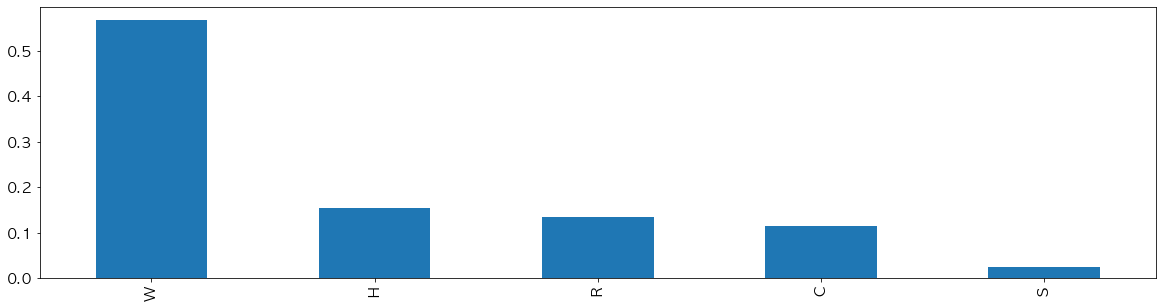

In [26]:
# value_counts에 대한 bar plot 생성
Train_df.ProductCD.value_counts(normalize=True).plot(kind = 'bar')

ProdudctCD  
W가 매우 높은 비율을 차지하며, S는 1% 가량됨을 확인

In [27]:
Train_df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.090941
H    0.021194
R    0.011078
S    0.026562
W    0.017871
Name: isFraud, dtype: float64

상품 코드 별로 차이가 존재함을 판단. 다만 H와 W는 거의 유사하다고 판단. -> T-test 수행 해보기  
상태 공간의 크기가 크지 않으므로 변수 값의 군집화는 생략하고 **더미화**


2.4.2 card4

In [29]:
Train_df['card4'].isnull().sum()
# 결측이 6개밖에 되지 않음 ==> 전부 최빈값으로 대체

6

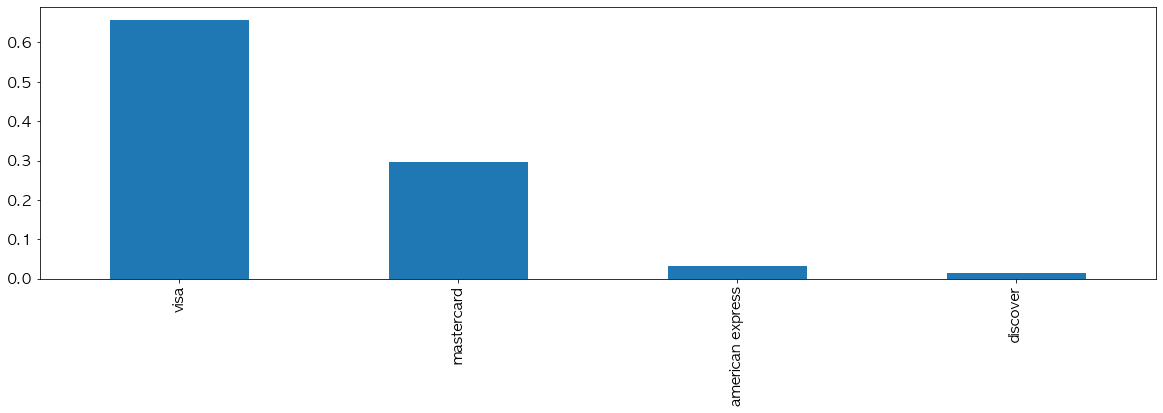

In [30]:
# value_counts에 대한 bar plot 생성
Train_df['card4'].value_counts(normalize = True).plot(kind = 'bar') 

visa와 master card가 매우 높은 비율을 차지하며, discover는 거의 없음

In [31]:
Train_df.groupby('card4')['isFraud'].mean()

card4
american express    0.010586
discover            0.025203
mastercard          0.029373
visa                0.025315
Name: isFraud, dtype: float64

거래의 대다수를 차지하는 visa와 mastercard의 값이 유사  
american express만 유독 값이 작으며 해당 값의 빈도가 높지 않음 => 해당 변수를 american express란 변수로 이진화  
따라서 결측을 특별히 제거할 필요가 없음  


=> 다른 카드의 종류에 따라 다른 정보와 묶으면 다른 의미있는 차이점이 나타나지 않을까? 그래서 다음과 같은 처리가 의심이 된다. => **검증해보자**

2.4.3 card6

In [33]:
Train_df['card6'].isnull().sum() 
# 결측이 4개밖에 되지 않음 ==> 전부 최빈값으로 대체

4

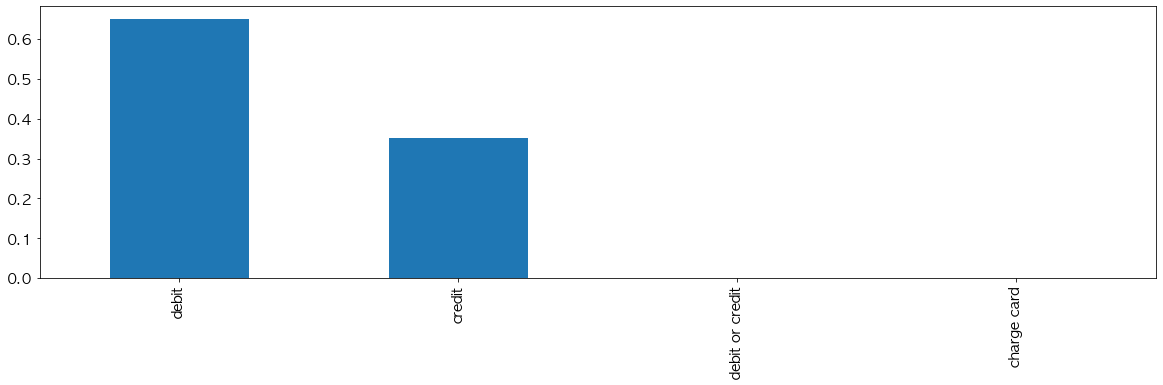

In [34]:
Train_df['card6'].value_counts(normalize = True).plot(kind = 'bar')
# debit과 credit이 대다수를 차지. 다른 값들은 육안으로 확인이 불가능한 수준

In [35]:
Train_df['card6'].value_counts(normalize = False) 
# debit or credit, charge card는 빈도가 매우 적음

debit              48673
credit             26318
debit or credit        3
charge card            2
Name: card6, dtype: int64

In [36]:
# credit과 debit의 차이가 존재
# charge card, debit or credit은 전부 0임을 확인 ==> 그러나 빈도 자체가 매우 적어서 그런 것이라 예상됨
# 따라서 credit인지 나타내는 변수로만 변환
Train_df.groupby('card6')['isFraud'].mean()

card6
charge card        0.000000
credit             0.037427
debit              0.019867
debit or credit    0.000000
Name: isFraud, dtype: float64

2.4.4 P_emaildomain과 R_emaildomain

- 이전 탐색에서 각각의 상태 공간 크기가 60, 61임을 확인 (대다수가 gmail 혹은 yahoo 메일임)
- 또한, 결측이 매우 많았는데, email이 결측이라는 것이 어떤 의미가 있을것이라 의심됨
- 샘플의 개수를 고려하더라도 그 크기가 큰 범주형 변수라고 판단 가능
- 두 변수간 관계가 있으리라 쉽게 판단 가능
- 또한, .를 기준으로 앞쪽에는 실제 도메인이, 뒤쪽에는 com, net 등이 포함되어 있어 분할 필요

In [40]:
Train_df['P_emaildomain'].value_counts() # gmail vs gmail.com etc...

gmail.com           27239
yahoo.com           11959
anonymous.com        6439
hotmail.com          6116
aol.com              3672
comcast.net          1410
icloud.com            641
msn.com               602
outlook.com           548
att.net               518
sbcglobal.net         483
verizon.net           463
live.com              366
bellsouth.net         336
cox.net               287
me.com                283
ymail.com             281
yahoo.com.mx          223
charter.net           159
optonline.net         158
mac.com                97
rocketmail.com         94
live.com.mx            93
earthlink.net          75
mail.com               60
embarqmail.com         57
roadrunner.com         53
gmail                  47
outlook.es             45
windstream.net         40
juno.com               40
frontier.com           38
hotmail.es             38
twc.com                36
netzero.com            34
frontiernet.net        33
cfl.rr.com             31
aim.com                31
web.de      

In [41]:
Train_df['R_emaildomain'].value_counts()

gmail.com           9852
anonymous.com       5195
hotmail.com         4072
yahoo.com           2412
aol.com             1008
comcast.net          597
outlook.com          316
icloud.com           229
yahoo.com.mx         223
msn.com              214
verizon.net          189
cox.net              160
sbcglobal.net        156
me.com               141
bellsouth.net        138
live.com             131
att.net              119
live.com.mx           93
ymail.com             63
mac.com               54
optonline.net         50
outlook.es            45
hotmail.es            38
mail.com              32
charter.net           30
web.de                27
prodigy.net.mx        27
embarqmail.com        24
juno.com              23
frontier.com          22
hotmail.fr            22
yahoo.fr              19
earthlink.net         19
rocketmail.com        17
roadrunner.com        16
windstream.net        15
cfl.rr.com            14
gmx.de                13
suddenlink.net        12
gmail                 12


In [42]:
# 결측이 의미가 있는지 확인 (두 변수 모두 결측이 많다는 것은 위에서 확인함)
# 결측을 나타내는 변수 생성
Train_df['NA_P_emaildomain'] = Train_df['P_emaildomain'].isnull().astype(int)
Train_df['NA_R_emaildomain'] = Train_df['R_emaildomain'].isnull().astype(int)

In [43]:
# P_emaildomain은 크게 문제 없어보임
# 0.002 차이나지 않는가? -> 다 반영하면 과적합 이슈에 부딪힐 수 있음
# 즉 확실한 근거가 반드시 필요함, 최대한 보수적으로 보는 편
Train_df.groupby('NA_P_emaildomain')['isFraud'].mean()

NA_P_emaildomain
0    0.026488
1    0.023672
Name: isFraud, dtype: float64

In [44]:
# R_emaildomain은 오히려 결측이 발생하지 않았을 때 사기인 경우가 더 많음을 확인 ==> 변수로 활용
Train_df.groupby('NA_R_emaildomain')['isFraud'].mean()

NA_R_emaildomain
0    0.043478
1    0.016838
Name: isFraud, dtype: float64

In [45]:
# 유의한 도메인만 가져와서 추가 탐색 수행
Train_df['P_emaildomain'] = Train_df['P_emaildomain'].str.split('.', expand = True).iloc[:, 0]
Train_df['R_emaildomain'] = Train_df['R_emaildomain'].str.split('.', expand = True).iloc[:, 0]

In [46]:
# P_emaildomain에 따른 isFraud의 평균 차이가 존재함
# 다만, aim.com, cableone.net 등은 그 빈도가 매우 적어서 이 차이가 유의한 것인지 판단이 불가 -> 판단 유보
Train_df.groupby('P_emaildomain')['isFraud'].mean()

P_emaildomain
aim             0.032258
anonymous       0.010561
aol             0.014978
att             0.007722
bellsouth       0.000000
cableone        0.000000
centurylink     0.000000
cfl             0.000000
charter         0.000000
comcast         0.008511
cox             0.003484
earthlink       0.000000
embarqmail      0.000000
frontier        0.000000
frontiernet     0.151515
gmail           0.035220
gmx             0.000000
hotmail         0.048666
icloud          0.039002
juno            0.000000
live            0.019565
mac             0.000000
mail            0.100000
me              0.021201
msn             0.016611
netzero         0.000000
optonline       0.000000
outlook         0.075885
prodigy         0.000000
protonmail      0.142857
ptd             0.000000
q               0.000000
roadrunner      0.000000
rocketmail      0.000000
sbcglobal       0.002070
sc              0.000000
servicios-ta    0.000000
suddenlink      0.000000
twc             0.000000
verizon    

In [47]:
# R_emaildomain에 따른 isFraud의 평균 차이가 존재함
# 다만, 대다수 값이 그 빈도가 매우 적어서 이 차이가 유의한 것인지 판단이 불가
Train_df.groupby('R_emaildomain')['isFraud'].mean()

R_emaildomain
aim             0.125000
anonymous       0.010202
aol             0.010913
att             0.000000
bellsouth       0.000000
cableone        0.000000
centurylink     0.000000
cfl             0.000000
charter         0.000000
comcast         0.015075
cox             0.012500
earthlink       0.000000
embarqmail      0.000000
frontier        0.000000
frontiernet     0.000000
gmail           0.064984
gmx             0.000000
hotmail         0.065475
icloud          0.043668
juno            0.000000
live            0.000000
mac             0.000000
mail            0.062500
me              0.000000
msn             0.004673
netzero         0.000000
optonline       0.000000
outlook         0.105263
prodigy         0.000000
protonmail      0.500000
ptd             0.000000
q               0.000000
roadrunner      0.000000
rocketmail      0.000000
sbcglobal       0.000000
scranton        0.000000
servicios-ta    0.000000
suddenlink      0.000000
twc             0.000000
verizon    

In [48]:
# 같은 거래라면 P_emaildomain과 R_emaildomain이 특정 관계가 있지 않을까?
# 파생 변수 추가 및 확인: 실제 라벨의 분포를 고려했을 때, 
# 1%와 5%의 차이는 꽤 큰 것이라 예상됨 ==> 해당 변수 사용
Train_df['same_emaildomain'] = (Train_df['P_emaildomain'] == Train_df['R_emaildomain']).astype(int)
print(Train_df['same_emaildomain'].value_counts())
print('\n')
print(Train_df.groupby('same_emaildomain')['isFraud'].mean()) # 이메일이 같은 경우에 사기확률이 상승함

0    56152
1    18848
Name: same_emaildomain, dtype: int64


same_emaildomain
0    0.016633
1    0.054117
Name: isFraud, dtype: float64


2.4.5 C3  

결측이 없음을 이전에서 확인  
변수 타입은 float인데, 상태 공간의 크기가 크지 않음 ==> 일단은 범주형으로 보는 것이 적절할 것 같음

In [50]:
# 0.0 값이 대다수임을 확인
Train_df['C3'].value_counts(normalize = True)

0.0    0.988747
1.0    0.010400
2.0    0.000693
3.0    0.000120
9.0    0.000013
8.0    0.000013
4.0    0.000013
Name: C3, dtype: float64

In [51]:
Train_df['C3'].value_counts(normalize = False)

0.0    74156
1.0      780
2.0       52
3.0        9
9.0        1
8.0        1
4.0        1
Name: C3, dtype: int64

In [52]:
# 2.0 이상의 값은 거의 존재하지 않기 때문에, 우연히 평균이 0이 나왔을 것이란 추측이 가능
# 0.0은 자주 등장했기 때문에, 라벨의 평균과 유사
# 1.0은 빈도가 어느정도 있음에도 불구하고 라벨의 평균과 크게 다름
# (조금은 위험한) 가설 수립: C3값이 1 이상인지 아닌지에 따른 차이가 존재할 것이다! => C3_over_1 변수 생성
Train_df.groupby('C3')['isFraud'].mean()

C3
0.0    0.026336
1.0    0.001282
2.0    0.000000
3.0    0.000000
4.0    0.000000
8.0    0.000000
9.0    0.000000
Name: isFraud, dtype: float64

In [53]:
Train_Y.value_counts(normalize = True) # C3 0.0이랑 Y=1이랑 상당히 비슷함

0    0.973947
1    0.026053
Name: isFraud, dtype: float64

2.4.6 M 관련 변수
- M1 - M9는 결측도 절반가까이를 포함하여, 대체하는 것은 어려을 것으로 예상됨
- 모두 범주형 변수이며, 값의 출현 패턴이 유사하니 동시에 탐색 수행

In [54]:
# 탐색을 위해, 모든 결측값을 우선 대체
M_columns = ['M' + str(i) for i in range(1, 10)]
Train_df[M_columns] = Train_df[M_columns].fillna("결측")

In [55]:
## 변수 분포 확인
# 1. 결측이 매우 많음 => 단순 대체 및 제거 불가
# 2. M4를 제외하고는 T (True), F (False로 정의됨)
for col in M_columns:
    print(Train_df[col].value_counts())
    print('\n')

결측    51321
T     23679
Name: M1, dtype: int64


결측    51321
T     21297
F      2382
Name: M2, dtype: int64


결측    51321
T     18486
F      5193
Name: M3, dtype: int64


결측    43113
M0    19708
M2     7115
M1     5064
Name: M4, dtype: int64


결측    51620
F     13011
T     10369
Name: M5, dtype: int64


결측    34232
F     21927
T     18841
Name: M6, dtype: int64


결측    62902
F     10357
T      1741
Name: M7, dtype: int64


결측    62902
F      7500
T      4598
Name: M8, dtype: int64


결측    62902
T     10407
F      1691
Name: M9, dtype: int64




In [56]:
## 변수 값별 라벨 확인: 값별로 차이가 있으며, 결측 자체로도 의미가 있어보임
# 즉, 결측이냐 아니냐에 따라서 Y의 차이가 나는 것을 직관적으로도 알 수 있다.
# 결측 자체로도 의미가 있으니, 결측을 따로 대체 후 더미화 필요
for col in M_columns:
    print(Train_df.groupby(col)['isFraud'].mean())
    print('\n')

M1
T     0.016681
결측    0.030377
Name: isFraud, dtype: float64


M2
F     0.034005
T     0.014744
결측    0.030377
Name: isFraud, dtype: float64


M3
F     0.027922
T     0.013524
결측    0.030377
Name: isFraud, dtype: float64


M4
M0    0.035722
M1    0.019945
M2    0.088405
결측    0.012061
Name: isFraud, dtype: float64


M5
F     0.018138
T     0.041373
결측    0.024971
Name: isFraud, dtype: float64


M6
F     0.023624
T     0.012101
결측    0.035289
Name: isFraud, dtype: float64


M7
F     0.013035
T     0.007467
결측    0.028711
Name: isFraud, dtype: float64


M8
F     0.013867
T     0.009569
결측    0.028711
Name: isFraud, dtype: float64


M9
F     0.013010
T     0.012107
결측    0.028711
Name: isFraud, dtype: float64




#### 2.5 연속형 변수 탐색
- 탐색방법  
(1) 변수별 분포 확인 (히스토그램)  
(2) 변수와 라벨 간 관계 파악 (박스플롯)  

- 탐색결과활용  
(1) 연속형 변수 이진화  
(2) 변수 치우침 제거  

- 선형관계가 보이지 않는 변수가 대부분이라 트리 기반의 앙상블 모델을 활용하기로 의사결정  

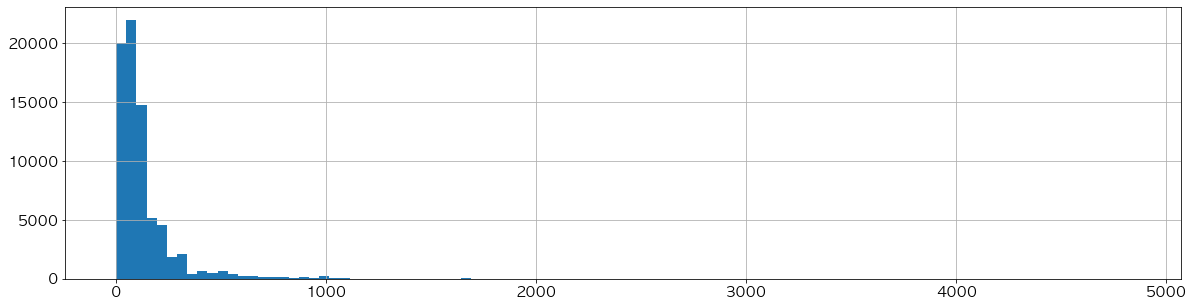

In [57]:
# 히스토그램 생성: 대다수가 1000달러 이하임을 확인 (거기다가 굉장히 치우침을 확인)
Train_df['TransactionAmt'].hist(bins = 100)

In [58]:
# 한쪽에 매우 치우침을 확인함: 거래 금액이 매우 크거나 작은 것 자체가 특징이 되지 않을까?
# 전부 양수이고, 굉장히 많이 퍼져있는 것을 알 수 있다. 75Q와 평균과 비슷하다
# max가 매우 크기 때문에, 의심을 해볼만함
Train_df['TransactionAmt'].describe()

count    75000.000000
mean       130.222620
std        206.503908
min          0.424000
25%         45.000000
50%         75.000000
75%        134.950000
max       4829.950000
Name: TransactionAmt, dtype: float64

([<matplotlib.axis.XTick at 0x7f823a2c0040>,
 [Text(0, 0, 'Fraud'), Text(0, 0, 'not Fraud')])

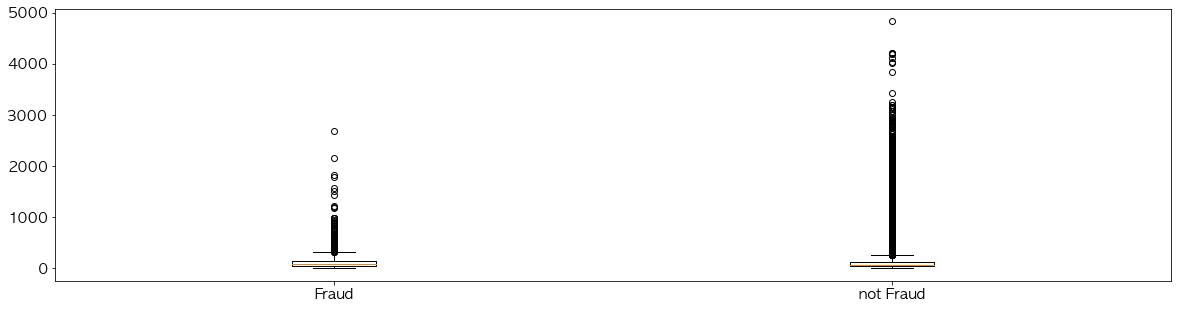

In [59]:
# 라벨과 연속형변수 비교
TransactionAmt_Fraud = Train_df['TransactionAmt'].loc[Train_df['isFraud'] == 1]
TransactionAmt_not_Fraud = Train_df['TransactionAmt'].loc[Train_df['isFraud'] == 0]

# 대부분 이상치로 판단되어 정상적인 해석이 쉽지 않음 (다만, Fraud인 경우의 범위가 더 좁음)
plt.boxplot([TransactionAmt_Fraud, TransactionAmt_not_Fraud])
plt.xticks([1, 2], ['Fraud', 'not Fraud'])

In [60]:
# 사기 거래의 경우
TransactionAmt_Fraud.describe()

count    1954.000000
mean      132.173121
std       178.683546
min         0.424000
25%        39.000000
50%        78.788000
75%       150.000000
max      2680.990000
Name: TransactionAmt, dtype: float64

In [61]:
# 사기 거래가 아닌 경우
# 평균의 차이는 비슷, 75% Quantile 차이가 조금 존재함
TransactionAmt_not_Fraud.describe()

count    73046.000000
mean       130.170443
std        207.197630
min          1.000000
25%         45.000000
50%         75.000000
75%        131.000000
max       4829.950000
Name: TransactionAmt, dtype: float64

In [62]:
# 사기 거래 유무에 따라 특별한 관계를 찾기는 어려움
# 또한, 사기 거래인 경우에는 데이터가 많아서 범위가 커보일 수 있음 
# 따라서 라벨과 관계를 고려하지 않고, 치우침만 해결하기로 결정

2.5.2 C 관련 변수 (범주형 변수 C3 제외)

In [63]:
# 변수 목록 생성
C_columns = ['C' + str(i) for i in range(1, 15) if i != 3]
C_columns

['C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [64]:
# 대다수의 변수가 75%값은 10미만인데, max값은 매우 큼 -> 이상하다? -> 90% 이상 파악해보기
Train_df[C_columns].describe()

,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000
mean,41.151000,47.912013,19.233333,4.17904,23.212640,15.887733,26.227787,3.277707,26.797080,29.765480,22.257813,45.584147,17.030920
std,312.502121,364.117106,158.342430,21.65999,159.083634,151.516922,231.963942,13.986498,232.707598,218.589395,212.667430,221.574753,104.011679
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000
75%,2.000000,2.000000,1.000000,1.00000,2.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,9.000000,2.000000
max,4682.000000,5690.000000,2251.000000,295.00000,2251.000000,2253.000000,3328.000000,194.000000,3254.000000,3186.000000,3186.000000,2915.000000,1426.000000


In [65]:
# 상위 90% 값 확인
Train_df[C_columns].quantile(0.90)

C1      6.0
C2      6.0
C4      1.0
C5      2.0
C6      4.0
C7      1.0
C8      1.0
C9      3.0
C10     1.0
C11     4.0
C12     1.0
C13    33.0
C14     5.0
Name: 0.9, dtype: float64